In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import random

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
exc = 0.4
inh = 0.322

In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [4]:
dur = 500.
t_pen = 0.7
int_t_pen = int((1.-t_pen)*dur/aln.params.dt)

In [5]:
file_ = '3_I.pickle'
folder = str(os.getcwd().split('data_2')[1])
print(folder)
case = '3'

/high_osc


In [6]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-10
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

p_var = [0]
c_var = [1]
wp = 1. / (dur - t_pen * dur)

if case in ['1', '2']:    # osc to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
else:
    factor_ws = 0.
    factor_we = 1.
    
maxC = [5., -5., 0.18, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [7]:
bestControl_ = None

if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]

file found


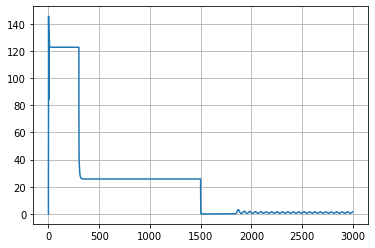

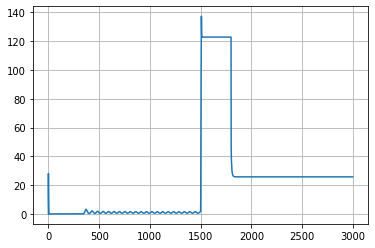

25.73160170281955
[1.17898505 0.62173334 0.52288618 0.89937247 1.46940135 1.37573782
 0.76735634 0.50087305 0.72655858 1.30945585 1.51115031 0.95992528
 0.53165845 0.59802359 1.10501279]


In [8]:
# get initial parameters and target states
data.set_parameters(aln)

aln.params.ext_exc_current = exc * 5.
aln.params.ext_inh_current = inh * 5.

aln.params.duration = 3000.

control0 = aln.getZeroControl()
control0 = functions.step_control(aln, maxI_ = max_I[0])

aln.run(control=control0)
plt.plot(aln.t, aln.rates_exc[0,:])
plt.show()

target_rates = np.zeros((2, int_t_pen))
target_rates[0,:] = aln.rates_exc[0,-int_t_pen:] 
target_rates[1,:] = aln.rates_inh[0,-int_t_pen:]

control0 = functions.step_control(aln, maxI_ = max_I[1])
aln.run(control=control0)
plt.plot(aln.t, aln.rates_exc[0,:])
plt.show()

init_state_vars = np.zeros(( len(state_vars) ))
for j in range(len(state_vars)):
    if aln.state[state_vars[j]].size == 1:
        init_state_vars[j] = aln.state[state_vars[j]][0]
    else:
        init_state_vars[j] = aln.state[state_vars[j]][0,-1]

initVars = init_state_vars
target = [target_rates[0,:], target_rates[1,:]]

print(initVars[0])
print(target[0][::100])

In [9]:
# get uncontrolled cost
    
aln.params.duration = dur

target_ = aln.getZeroTarget()
target_[:,0,-int_t_pen:] = target[0]
target_[:,1,-int_t_pen:] = target[1]

cost.setParams(wp, 0.0, 0.0)

setinit(initVars, aln)
control0 = aln.getZeroControl()

cgv = None
max_it = 0

bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
    control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
    startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
    t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
    prec_variables_ = p_var, transition_time_ = t_pen)

cost_uncontrolled = cost_init_[0]

set cost params:  0.006666666666666667 0.0 0.0
interpolate adjoint :  True True True
initial cost =  307.22769784192036
RUN  0 , total integrated cost =  307.22769784192036
Gradient descend method:  None
RUN  0 , total integrated cost =  307.22769784192036
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


set cost params:  0.006666666666666667 0.0 10.0
interpolate adjoint :  True True True
initial cost =  154.9797323921401
RUN  0 , total integrated cost =  154.9797323921401
Gradient descend method:  None
RUN  1 , total integrated cost =  136.9103292529824
RUN  2 , total integrated cost =  136.58125469327106
RUN  3 , total integrated cost =  136.55199187904216
RUN  4 , total integrated cost =  136.55183096871215
RUN  5 , total integrated cost =  136.55161419815744
RUN  6 , total integrated cost =  136.5514006768173
RUN  7 , total integrated cost =  136.5512377898627
RUN  8 , total integrated cost =  136.55108598129516
RUN  9 , total integrated cost =  136.48446611262284
RUN  10 , total integrated cost =  136.45352143469412
RUN  10 , total integrated cost =  136.45352143469412
Improved over  10  iterations in  22.18468794398359  seconds by  11.953957250726006  percent.


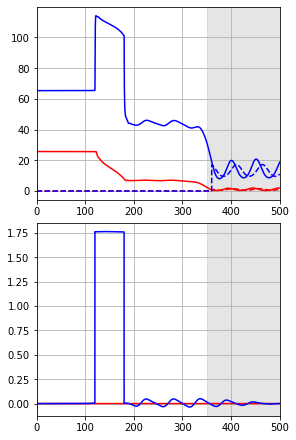

uncontrolled cost :  307.22769784192036
cost splitting :  6.40165738963164 [ 0.         13.64108437]


In [10]:
cgv = None
j = 0

aln.params.duration = dur
setinit(initVars, aln)

target_ = aln.getZeroTarget()
target_[:,0,-int_t_pen:] = target[0]
target_[:,1,-int_t_pen:] = target[1]

control0 = aln.getZeroControl()
cost.setParams(wp, 0., 10.)
max_it = int(10)

control0[0,1,1200:1800] = 2.

bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
    control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
    startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
    t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
    prec_variables_ = p_var, transition_time_ = t_pen)

if True:
    plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
    target_ = aln.getZeroTarget()
    target_[:,0,-int_t_pen:] = target[0]
    target_[:,1,-int_t_pen:] = target[1]

    fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,6) )
    ax[1].plot(plot_time_array, bestControl_[0,0,n_pre-1:-n_post+1], color = 'red')
    ax[0].plot(plot_time_array, bestState_[0,0,n_pre-1:-n_post+1], color= 'red')
    ax[1].plot(plot_time_array, bestControl_[0,1,n_pre-1:-n_post+1], color = 'blue')
    ax[0].plot(plot_time_array, bestState_[0,1,n_pre-1:-n_post+1], color= 'blue')
    ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
    ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

    for k in range(2):
        ax[k].set_xlim(0.,dur)
        ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()

print('uncontrolled cost : ', cost_uncontrolled)
print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])    

set cost params:  0.006666666666666667 0.0 16.73417879397327
interpolate adjoint :  True True True
initial cost =  228.3150225385839
RUN  0 , total integrated cost =  228.3150225385839
Gradient descend method:  None
RUN  1 , total integrated cost =  228.3150225385839
Control only changes marginally.
RUN  1 , total integrated cost =  228.3150225385839
Improved over  1  iterations in  0.7091084790008608  seconds by  0.0  percent.
cost splitting :  6.40165738963164 [ 0.         13.64108437]


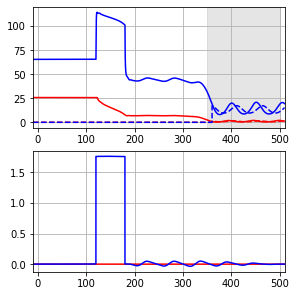

In [11]:
c_var = [0,1]
max_it = int(30)
conv = False

tol = 1e-6
    
while not conv:

    weight_ = random.random() * ( cost_uncontrolled -
                                 costnode_[0][0][0] ) / sum( costnode_[2][0][:] )

    aln.params.duration = dur
    cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
    weights_ = cost.getParams()

    setinit(initVars, aln)

    target_ = aln.getZeroTarget()
    target_[:,0,-int_t_pen:] = target[0]
    target_[:,1,-int_t_pen:] = target[1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[:,:,n_pre-1:-n_post+1]

    bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if cost_[3] == 0.:
        conv = True

    #print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])

    if conv and True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,-int_t_pen:] = target[0]
        target_[:,1,-int_t_pen:] = target[1]

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_[0,0,:], color = 'red')
        ax[0].plot(time_, bestState_[0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_[0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_[0,1,:], color= 'blue')
        ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
        ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
        ax[0].set_xlim(-dur_pre,dur+dur_post)
        ax[1].set_xlim(-dur_pre,dur+dur_post)
        ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    with open(file_,'wb') as f:
        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

set cost params:  0.006666666666666667 0.0 9.514200666505879
interpolate adjoint :  True True True
initial cost =  129.82669173869954
RUN  0 , total integrated cost =  129.82669173869954
Gradient descend method:  None
RUN  1 , total integrated cost =  129.82660101908007
RUN  2 , total integrated cost =  129.82660101908007
Control only changes marginally.
RUN  2 , total integrated cost =  129.82660101908007
Improved over  2  iterations in  1.6393804679973982  seconds by  6.987747916298304e-05  percent.
cost splitting :  6.388529483419177 [ 0.         13.64108404]


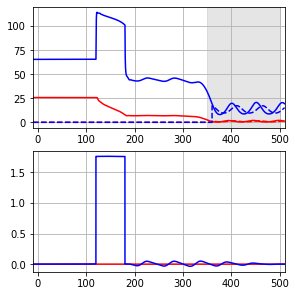

In [12]:
c_var = [0,1]
max_it = int(30)
conv = False

tol = 1e-8
    
while not conv:

    weight_ = random.random() * ( cost_uncontrolled -
                                 costnode_[0][0][0] ) / sum( costnode_[2][0][:] )

    aln.params.duration = dur
    cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
    weights_ = cost.getParams()

    setinit(initVars, aln)

    target_ = aln.getZeroTarget()
    target_[:,0,-int_t_pen:] = target[0]
    target_[:,1,-int_t_pen:] = target[1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[:,:,n_pre-1:-n_post+1]

    bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if cost_[3] == 0.:
        conv = True

    #print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])

    if conv and True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,-int_t_pen:] = target[0]
        target_[:,1,-int_t_pen:] = target[1]

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_[0,0,:], color = 'red')
        ax[0].plot(time_, bestState_[0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_[0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_[0,1,:], color= 'blue')
        ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
        ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
        ax[0].set_xlim(-dur_pre,dur+dur_post)
        ax[1].set_xlim(-dur_pre,dur+dur_post)
        ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    with open(file_,'wb') as f:
        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

set cost params:  0.006666666666666667 0.0 4.226921668765698
interpolate adjoint :  True True True
initial cost =  57.70238389171251
RUN  0 , total integrated cost =  57.70238389171251
Gradient descend method:  None
RUN  1 , total integrated cost =  57.70238371173993
RUN  2 , total integrated cost =  57.70238371173993
Control only changes marginally.
RUN  2 , total integrated cost =  57.70238371173993
Improved over  2  iterations in  1.2437134139763657  seconds by  3.118979918781406e-07  percent.
cost splitting :  6.388511473499932 [ 0.         13.64108402]


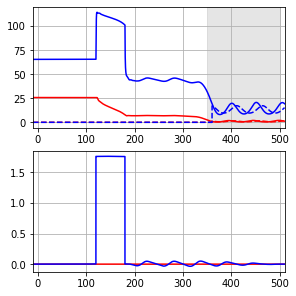

In [13]:
c_var = [0,1]
max_it = int(30)
conv = False

tol = 1e-10
    
while not conv:

    weight_ = random.random() * ( cost_uncontrolled -
                                 costnode_[0][0][0] ) / sum( costnode_[2][0][:] )

    aln.params.duration = dur
    cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
    weights_ = cost.getParams()

    setinit(initVars, aln)

    target_ = aln.getZeroTarget()
    target_[:,0,-int_t_pen:] = target[0]
    target_[:,1,-int_t_pen:] = target[1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[:,:,n_pre-1:-n_post+1]

    bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if cost_[3] == 0.:
        conv = True

    #print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])

    if conv and True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,-int_t_pen:] = target[0]
        target_[:,1,-int_t_pen:] = target[1]

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_[0,0,:], color = 'red')
        ax[0].plot(time_, bestState_[0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_[0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_[0,1,:], color= 'blue')
        ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
        ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
        ax[0].set_xlim(-dur_pre,dur+dur_post)
        ax[1].set_xlim(-dur_pre,dur+dur_post)
        ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    with open(file_,'wb') as f:
        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

set cost params:  0.006666666666666667 0.0 14.725643243205385
interpolate adjoint :  True True True
initial cost =  200.916031156471
RUN  0 , total integrated cost =  200.916031156471
Gradient descend method:  None
RUN  1 , total integrated cost =  200.9160311336534
RUN  2 , total integrated cost =  200.91602966052142
RUN  3 , total integrated cost =  200.9160284655138
RUN  4 , total integrated cost =  200.91602844974813
RUN  5 , total integrated cost =  200.91600651512422
RUN  6 , total integrated cost =  200.91599021301923
RUN  7 , total integrated cost =  200.91598958720814
RUN  8 , total integrated cost =  200.9159888729758
RUN  9 , total integrated cost =  200.91598885341074
RUN  10 , total integrated cost =  200.9159869076115
RUN  11 , total integrated cost =  200.91598536386985
RUN  12 , total integrated cost =  200.9159853350538
RUN  13 , total integrated cost =  200.915984437981
RUN  14 , total integrated cost =  200.91598344034344
RUN  15 , total integrated cost =  200.915983

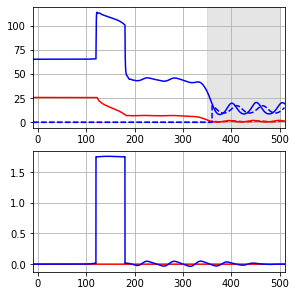

In [16]:
c_var = [0,1]
max_it = int(30)
conv = False

tol = 1e-20
    
while not conv:

    weight_ = random.random() * ( cost_uncontrolled -
                                 costnode_[0][0][0] ) / sum( costnode_[2][0][:] )

    aln.params.duration = dur
    cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
    weights_ = cost.getParams()

    setinit(initVars, aln)

    target_ = aln.getZeroTarget()
    target_[:,0,-int_t_pen:] = target[0]
    target_[:,1,-int_t_pen:] = target[1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[:,:,n_pre-1:-n_post+1]

    bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if cost_[3] == 0.:
        conv = True

    #print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])

    if conv and True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,-int_t_pen:] = target[0]
        target_[:,1,-int_t_pen:] = target[1]

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_[0,0,:], color = 'red')
        ax[0].plot(time_, bestState_[0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_[0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_[0,1,:], color= 'blue')
        ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
        ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
        ax[0].set_xlim(-dur_pre,dur+dur_post)
        ax[1].set_xlim(-dur_pre,dur+dur_post)
        ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    with open(file_,'wb') as f:
        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)